In [10]:
##%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
import os
from xmitgcm import open_mdsdataset
from xmitgcm.utils import get_grid_from_input, get_extra_metadata

from myutils import *
from MITgcmutils import llc
import xarray as xr
import cmocean.cm as cmo
#import cartopy.crs as ccrs
import cartopy as cart

def sq(a):
    import numpy as np
    a = np.squeeze(a)
    masked_array=np.ma.masked_where(a==0., a)
    return masked_array

def mosaic_llc(field):
    return np.vstack([np.hstack([np.vstack([np.rot90(field[i]) for i in [9,8,7]]),
                                 np.vstack([np.rot90(field[i]) for i in [12,11,10]]),
                                 np.vstack([field[i] for i in [0,1,2]]),
                                 np.vstack([field[i] for i in [3,4,5]])]),
                      np.hstack([np.rot90(field[6])*np.tri(90)[::-1,:],np.triu(np.rot90(field[6],k=2))*np.tri(90)[::-1,:],
                                 np.triu(np.rot90(field[6],k=-1)),np.zeros(field[6].shape)])])[30:315,:]

def llc13to5faces(field):
    """
    fld = llc13to5faces(field) returns a list of 5 faces constructed from 
    the input of a 13-faces field as returned from 
    xmitgcm.open_mdsdataset(...,geometry='llc')
    """
    return [np.vstack((field[0,...],field[1,...],field[2,...])),
            np.vstack((field[3,...],field[4,...],field[5,...])),
            field[6,...],
            np.hstack((field[7,...],field[8,...],field[9,...])),
            np.hstack((field[10,...],field[11,...],field[12,...]))]

def symNorm(vmax):
    import matplotlib.colors as mcolors
    return mcolors.Normalize(vmin=-vmax,vmax=vmax)

def flat2d(x):
    x0 = xr.concat( [xr.concat( [x.isel(face=0),x.isel(face=1),x.isel(face=2)], dim = 'j' ),
                     xr.concat( [x.isel(face=3),x.isel(face=4),x.isel(face=5)], dim = 'j' )], dim='i' )
    y0 = xr.concat( [xr.concat( [x.isel(face=7),x.isel(face=8),x.isel(face=9)], dim = 'i' ),
                     xr.concat( [x.isel(face=10),x.isel(face=11),x.isel(face=12)], dim = 'i' )], dim='j' )
    return np.concatenate((x0,np.rot90(y0,k=1,axes=(-2,-1))), axis=-1)

def calc_drake_passage_transport(ds):
    vtrans = (ds.VVEL*ds.hFacS*ds.drF).sum('k')*ds.dxG * 1e-6
    return (vtrans.sel(face=11,i=range(87,90),j_g=62).sum('i') + vtrans.sel(face=12,i=range(20),j_g=62).sum('i'))

def compute_moc(wflux):
    u0 = xr.concat( [xr.concat( [wflux.isel(face=0),wflux.isel(face=1),wflux.isel(face=2)], dim = 'j' ),
                     xr.concat( [wflux.isel(face=3),wflux.isel(face=4),wflux.isel(face=5)], dim = 'j' )], dim='i' )
    v0 = xr.concat( [xr.concat( [wflux.isel(face=7),wflux.isel(face=8),wflux.isel(face=9)], dim = 'i' ),
                     xr.concat( [wflux.isel(face=10),wflux.isel(face=11),wflux.isel(face=12)], dim = 'i' )], dim='j' )
    wflx = (np.concatenate((u0,np.rot90(v0,k=1,axes=(-2,-1))), axis=-1)).sum(axis=-1)
    # order of integration: from north to south because of Atlantic MOC, require sign change
    mocstrf = -np.flip(np.flip(wflx,axis=-1).cumsum(axis=-1),axis=-1)
    mocstrf[wflx==0]=0.
    return mocstrf

In [11]:
deltat=1800.
ny, nx = 1170, 90
prefix=['diags2D','diags3D','diagsGGL90']

bdir='/work/ollie/mlosch/idemix_test/llc90'
fdir='/home/ollie/mlosch/MITgcm/MITgcm/idemix_test/llc90/figs'
rdir0='/work/ollie/mlosch/idemix_test/llc90/run00' # first attempt with little overturning left after 62 years, viscA4grid=0.01, 300 days for salinity restoring, 10m/300days = 3.8580246913580245e-07 m/s
rdir0='/work/ollie/mlosch/idemix_test/llc90/run01' # increase salinity restoring (90days for 10m: 10m/90days = 1.286008230452675e-06 m/s, more viscosity viscA4grid=0.05)
rdir1='/work/ollie/mlosch/idemix_test/llc90/run01_idemix' # same as run01 with idemix
rdir0='/work/ollie/mlosch/idemix_test/llc90/run03' # like run01 with 60 days for salinity restoring, 10m/60days = 1.9290123456790124e-06 m/s)
rdir1='/work/ollie/mlosch/idemix_test/llc90/run03_idemix' # same as run03 with idemix
rname0='CTRL'
rname1='IDEMIX'

# rdir0,rname0='/work/ollie/mlosch/idemix_test/llc90/run00','run00' # first attempt with little overturning left after 62 years, viscA4grid=0.01, 300 days for salinity restoring, 10m/300days = 3.8580246913580245e-07 m/s
# rdir1,rname1='/work/ollie/mlosch/idemix_test/llc90/run01','run01' # increase salinity restoring (90days for 10m: 10m/90days = 1.286008230452675e-06 m/s, more viscosity viscA4grid=0.05)
# rdir0,rname0='/work/ollie/mlosch/idemix_test/llc90/run02','run02' # like run01 without salinity restoring 
# rdir0,rname0='/work/ollie/mlosch/idemix_test/llc90/run01','run01' # increase salinity restoring (90days for 10m: 10m/90days = 1.286008230452675e-06 m/s, more viscosity viscA4grid=0.05)
# rdir1,rname1='/work/ollie/mlosch/idemix_test/llc90/run03','run03' # like run01 with 60 days for salinity restoring, 10m/60days = 1.9290123456790124e-06 m/s)

In [12]:
# We generate the extra metadata needed for multi-faceted grids
llc90_extra_metadata = get_extra_metadata(domain='llc', nx=90)
grid = get_grid_from_input(os.path.join('/home/ollie/mlosch/MITgcm/nils/llc90/input','tile<NFACET>.mitgrid'),
                           geometry='llc', extra_metadata=llc90_extra_metadata)

In [13]:
ds0 = open_mdsdataset(os.path.join(rdir0),prefix=prefix,
                     delta_t=deltat,ref_date="1958-1-1 0:0:0",geometry='llc')
coords = ds0.coords.to_dataset().reset_coords()
#ds = ds0.reset_coords(drop=True)
# fix coordinates
ds0.coords['XC'] = grid.XC
ds0.coords['YC'] = grid.YC
ds0

<xarray.Dataset>
Dimensions:   (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, face: 13, time: 186)
Coordinates: (12/45)
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...        ...
    dxV       (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dxF       (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rhoRef    (k) >f4 dask.array<chunksize=(50,), meta=np.ndarray>
    dyU       (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) datetime64[ns] 1959-01-01 1960-01-01 ... 2144-01-01
Data variables: (12/16)
    THETA     (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    SALT      (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    DRHODR    (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    UVEL      (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    VVEL      (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    WVEL      (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    ...        ...
    GGL90ArU  (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90ArV  (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    ETAN      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    MXLDEPTH  (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceFWflx  (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceQnet   (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [14]:
ds1 = open_mdsdataset(os.path.join(rdir1),prefix=prefix,
                     delta_t=deltat,ref_date="1958-1-1 0:0:0",geometry='llc')
coords = ds1.coords.to_dataset().reset_coords()
#ds = ds0.reset_coords(drop=True)
# fix coordinates
ds1.coords['XC'] = grid.XC
ds1.coords['YC'] = grid.YC
ds1

<xarray.Dataset>
Dimensions:   (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, face: 13, time: 186)
Coordinates: (12/45)
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...        ...
    dxV       (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dxF       (face, j, i) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rhoRef    (k) >f4 dask.array<chunksize=(50,), meta=np.ndarray>
    dyU       (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) datetime64[ns] 1959-01-01 1960-01-01 ... 2144-01-01
Data variables: (12/16)
    THETA     (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    SALT      (time, k, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    DRHODR    (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    UVEL      (time, k, face, j, i_g) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    VVEL      (time, k, face, j_g, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    WVEL      (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    ...        ...
    GGL90ArU  (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    GGL90ArV  (time, k_l, face, j, i) float32 dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    ETAN      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    MXLDEPTH  (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceFWflx  (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    oceQnet   (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

barotropic stream function

In [15]:
plt.close('all')
mytindex=ds1.time.shape[0]-1
mytime=ds1.time.isel(time=mytindex)
yearstr = str(ds0.time.sel(time=mytime).data.astype('datetime64[Y]'))

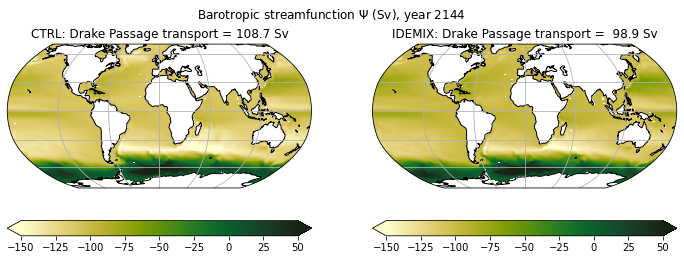

In [16]:
def plotbarostream(ax,ds,tstr='dummy'):
    
    utrans = (ds.UVEL.sel(time=mytime)*ds.hFacW*ds.drF).sum('k')*ds.dyG * 1e-6
    vtrans = (ds.VVEL.sel(time=mytime)*ds.hFacS*ds.drF).sum('k')*ds.dxG * 1e-6

    u0 = xr.concat( [xr.concat( [utrans.isel(face=0),utrans.isel(face=1),utrans.isel(face=2)], dim = 'j' ),
                     xr.concat( [utrans.isel(face=3),utrans.isel(face=4),utrans.isel(face=5)], dim = 'j' )], dim='i_g' )
    v0 = xr.concat( [xr.concat( [vtrans.isel(face=7),vtrans.isel(face=8),vtrans.isel(face=9)], dim = 'i' ),
                     xr.concat( [vtrans.isel(face=10),vtrans.isel(face=11),vtrans.isel(face=12)], dim = 'i' )], dim='j_g' )

    uu = np.concatenate((u0,np.fliplr(v0).transpose()), axis=-1)
    xx = flat2d(grid.XC)
    xt = xx[:,150:]
    xt[xt<0] = xt[xt<0]+360.
    xx[:,150:]=xt
    yy = flat2d(grid.YC)
    barostream = - uu.cumsum(axis=-2)
    barostream[uu==0]=0.
#   drake_passage_transport = mosaic_llc(vtrans)[40:63,152].sum()
    drake_passage_transport = calc_drake_passage_transport(ds.sel(time=mytime))
    # csf=ax.pcolormesh(np.concatenate((xx-360,xx,xx+360), axis=-1),
    #                   np.concatenate((yy,yy,yy), axis=-1),
    #                   sq(np.concatenate((barostream,barostream,barostream), axis=-1)), 
    csf=ax.pcolormesh(xx, yy, sq(barostream), 
                      transform=cart.crs.PlateCarree(),
                      norm=colors.Normalize(vmin=-150,vmax=50),cmap=cmo.speed) #.where(utmp!=0).plot()
    plt.colorbar(csf,ax=ax,orientation='horizontal',extend='both')
    ax.set_title('%s: Drake Passage transport = %5.1f Sv'%(
        tstr,drake_passage_transport))
    ax.coastlines()
    ax.gridlines()
    #plt.axis('tight')
    #ax.set_xlim([-38,322])

proj=cart.crs.Robinson()#central_longitude=180.0-19) #central_longitude=7.0)
#proj=cart.crs.PlateCarree() #central_longitude=161.)

fig, ax = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(12,4),subplot_kw={'projection': proj})
plotbarostream(ax[0],ds0,tstr=rname0)
plotbarostream(ax[1],ds1,tstr=rname1)

fig.suptitle('Barotropic streamfunction $\Psi$ (Sv), year %s'%(ds0.time.sel(time=mytime).data.astype('datetime64[Y]')))

fig.savefig(os.path.join(fdir,'%s_%s'%('barostream',yearstr)),dpi=300)

overturning stream function from w

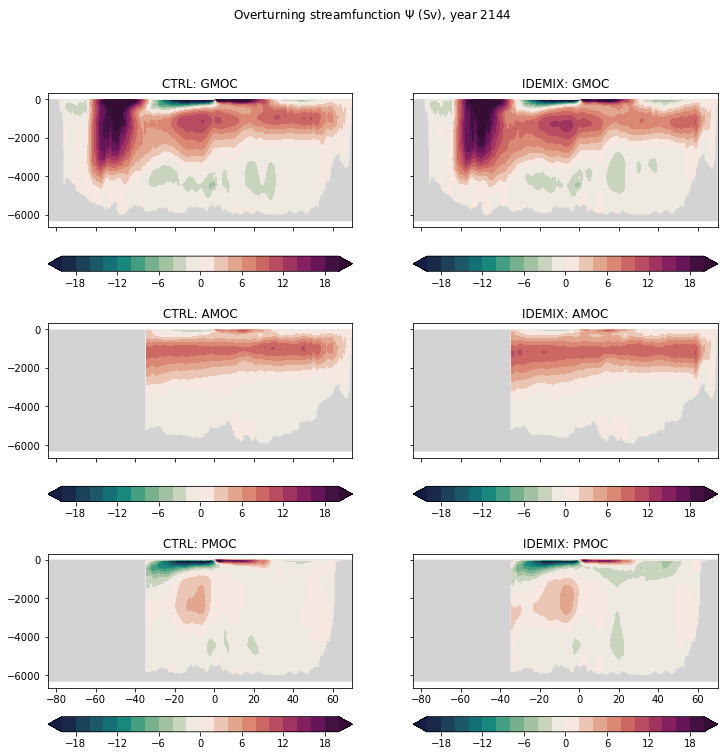

In [17]:
#mytindex = ds1.time.shape[0]-1
#mytindex = 0
mytime=ds1.time.isel(time=mytindex)

def plotmoc(ax,ds,msk,tstr='dummy'):
    mocstrf = compute_moc(ds.WVEL.sel(time=mytime)*(ds0.rA*msk)*1e-6)
    # # wflx = flat2d(wflux).sum(axis=-1) # somehow, this does not work, so we spell it out:
    # u0 = xr.concat( [xr.concat( [wflux.isel(face=0),wflux.isel(face=1),wflux.isel(face=2)], dim = 'j' ),
    #                  xr.concat( [wflux.isel(face=3),wflux.isel(face=4),wflux.isel(face=5)], dim = 'j' )], dim='i' )
    # v0 = xr.concat( [xr.concat( [wflux.isel(face=7),wflux.isel(face=8),wflux.isel(face=9)], dim = 'i' ),
    #                  xr.concat( [wflux.isel(face=10),wflux.isel(face=11),wflux.isel(face=12)], dim = 'i' )], dim='j' )
    # wflx = (np.concatenate((u0,np.rot90(v0,k=1,axes=(-2,-1))), axis=-1)).sum(axis=-1)
    # # print(wflx.shape)
    # # order of integration: from north to south because of Atlantic MOC, require sign change
    # mocstrf = -np.flip(np.flip(wflx,axis=-1).cumsum(axis=-1),axis=-1)
    # mocstrf[wflx==0]=0.
    yy = flat2d(grid.YC)
    dd = flat2d(ds.Depth*msk)
    d = dd.max(axis=-1)
    y = yy.mean(axis=-1)
    #y = np.arange(y.shape[0])
    #csf=ax.pcolormesh(y,ds0.Zu,sq(mocstrf),norm=symNorm(20),cmap=cmo.curl)#,vmin=-20,vmax=20)
    csf=ax.contourf(y,ds.Zu,sq(mocstrf),levels=np.linspace(-20,20,21),cmap=cmo.curl, extend='both')
    ax.fill_between(y,-d,-ds.drF.sum()-200,step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='horizontal',extend='both')
    ax.set_title('%s'%(tstr))
    plt.axis('tight')
    plt.grid()

global_mask = coords.hFacC.isel(k=0).where(coords.YC<70).fillna(0)
atlantic_mask = coords.hFacC.isel(k=0).where(
    np.logical_and(coords.YC>-35,coords.YC<70)).where( # Southern Ocean and Arctic
    np.logical_and(coords.XC<20,coords.XC>-98)).where( # most of the non-Atlantic Ocean
    np.logical_or(coords.XC<0,np.logical_or(coords.YC<30,coords.YC>47))).where(
    np.logical_or(coords.XC<-9,np.logical_or(coords.YC<34,coords.YC>38))).where( # Strait of Gibraltar
    np.logical_or(coords.XC>-70,coords.YC>9)).where( # East Pacific 
    np.logical_or(coords.XC>-84,coords.YC>14)).where( # Isthmus of Panama etc.
    np.logical_or(coords.XC>-90,coords.YC>18)).where(
    np.logical_or(coords.XC>-70,coords.YC<50)).fillna(0)
indopacific_mask = (global_mask-atlantic_mask).where(
    np.logical_and(coords.YC>-35,coords.YC<70)).fillna(0)
# remove Hudson
indopacific_mask[10,10:,:39] = 0.
# remove Med and parts of Arctic
indopacific_mask[ 2,20:,29:84] = 0.
# remove Bering strait and Chukchy Sea
indopacific_mask[ 7,:,:14] = 0.

fig, ax = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,figsize=(12,12))#, subplot_kw={'projection': proj})
plotmoc(ax[0,0],ds0,global_mask,tstr=rname0+': GMOC')
plotmoc(ax[0,1],ds1,global_mask,tstr=rname1+': GMOC')
plotmoc(ax[1,0],ds0,atlantic_mask,tstr=rname0+': AMOC')
plotmoc(ax[1,1],ds1,atlantic_mask,tstr=rname1+': AMOC')
plotmoc(ax[2,0],ds0,indopacific_mask,tstr=rname0+': PMOC')
plotmoc(ax[2,1],ds1,indopacific_mask,tstr=rname1+': PMOC')


fig.suptitle('Overturning streamfunction $\Psi$ (Sv), year %s'%(ds0.time.sel(time=mytime).data.astype('datetime64[Y]')))
fig.savefig(os.path.join(fdir,'%s_%s'%('moc',yearstr)),dpi=300)

zonally averated density/salinity/temperature/`K`/`K*N^2`

/tmp/ipykernel_94036/2710024508.py:40: UserWarning: Log scale: values of z <= 0 have been masked
  csf=ax.contourf(y,z,fld0,levels=levs,norm=cnorm,extend='both',cmap=cmap)
/tmp/ipykernel_94036/2710024508.py:40: UserWarning: Log scale: values of z <= 0 have been masked
  csf=ax.contourf(y,z,fld0,levels=levs,norm=cnorm,extend='both',cmap=cmap)
/tmp/ipykernel_94036/2710024508.py:40: UserWarning: Log scale: values of z <= 0 have been masked
  csf=ax.contourf(y,z,fld0,levels=levs,norm=cnorm,extend='both',cmap=cmap)
/tmp/ipykernel_94036/2710024508.py:40: UserWarning: Log scale: values of z <= 0 have been masked
  csf=ax.contourf(y,z,fld0,levels=levs,norm=cnorm,extend='both',cmap=cmap)


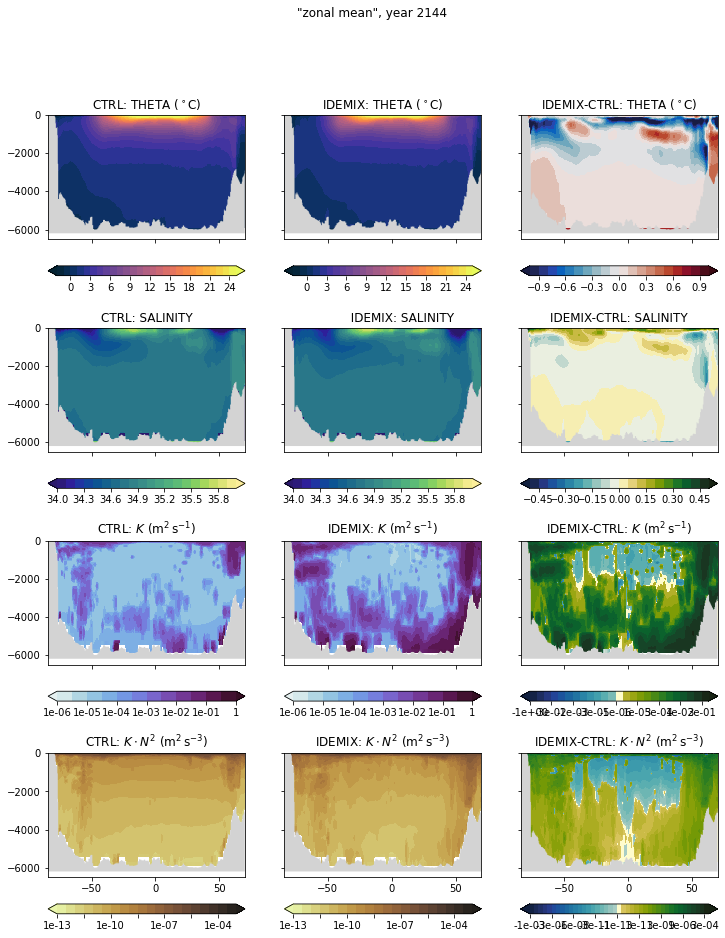

In [18]:
#plt.close('all')
import matplotlib.ticker as mtick
#mytindex = ds1.time.shape[0]-1
mytime=ds1.time.isel(time=mytindex)

def format_func(x,pos):
    mystr = "%1.0e"%x
    return mystr

def plotzonalmean(ax,ds,fld,levs,tstr='dummy',cmap=None):
    # compute zonal mean along grid lines for now:
    y = flat2d(grid.YC).mean(axis=-1)
    dvol = flat2d(ds0.hFacC*ds0.rA*ds0.drF)
    # mask the Med
    dvol[:,200:217,33:80]=0
    dvol[:,217:222,40:60]=0
    ra = dvol.sum(axis=-1)
    ra[ra==0]=np.Inf
    fld0 = (flat2d(fld.sel(time=mytime))*dvol).sum(axis=-1)/ra
    d = flat2d(ds.Depth).max(axis=-1)
    if fld.dims[1]=='k_l':
        # in this case we assume that we want to plot logarithmic color scales
        z = ds.Zl
        tickformat=mtick.LogFormatter()
        useLog=True
        if levs[0]>0:
            cnorm = colors.LogNorm(levs[0],levs[-1])
        else:
            # special trick, when logarithmic levels are negative use symmetric log scale
            cnorm = colors.SymLogNorm(linthresh=np.abs(levs[0]), linscale=2,
                                      vmin=-np.abs(levs[-1]),vmax=np.abs(levs[-1]))        
            levs = np.hstack((np.flip(levs),-levs))
            # cnorm = colors.Normalize(vmin=-np.abs(levs[-1]),vmax=np.abs(levs[-1]))        
            tickformat=mtick.FuncFormatter(format_func)
    else:
        z = ds.Z
        useLog=False
        cnorm = None
    csf=ax.pcolormesh(y,z,sq(fld0),norm=cnorm,cmap=cmap)
    csf=ax.contourf(y,z,fld0,levels=levs,norm=cnorm,extend='both',cmap=cmap)
    ax.fill_between(y,-d,-ds.Depth.max()-200.,step='mid',facecolor='lightgrey')
    if useLog:
        plt.colorbar(csf,ax=ax,orientation='horizontal',format=tickformat)
    else:
        plt.colorbar(csf,ax=ax,orientation='horizontal')
    ax.set_title('%s'%(tstr))

# N2 = - gravity/rho0 * DRHODR 
gr = 9.81/1035
# plt.close('all')
# fig,ax=plt.subplots(1,1,figsize=(12,15),sharex=True,sharey=True);
# plotzonalmean(ax,ds1,(ds1-ds0).GGL90Kr,-np.logspace(-6,0,7),'%s-%s: $K$ (m$^{2}\,$s$^{-1}$)'%(rname1,rname0),cmap=cmo.delta)

fig,ax=plt.subplots(4,3,figsize=(12,15),sharex=True,sharey=True);
plotzonalmean(ax[0,0],ds0,ds0.THETA,np.linspace(-2,25,28),        '%s: THETA ($^\circ$C)'%rname0,cmap=cmo.thermal)
plotzonalmean(ax[0,1],ds1,ds1.THETA,np.linspace(-2,25,28),        '%s: THETA ($^\circ$C)'%rname1,cmap=cmo.thermal)
plotzonalmean(ax[0,2],ds0,(ds1-ds0).THETA,np.linspace(-1,1,21),'%s-%s: THETA ($^\circ$C)'%(rname1,rname0),cmap=cmo.balance)
plotzonalmean(ax[1,0],ds0,ds0.SALT, np.linspace(34,36,21),          '%s: SALINITY'%rname0,cmap=cmo.haline)
plotzonalmean(ax[1,1],ds1,ds1.SALT, np.linspace(34,36,21),'          %s: SALINITY'%rname1,cmap=cmo.haline)
plotzonalmean(ax[1,2],ds0,(ds1-ds0).SALT, np.linspace(-.5,.5,21),'%s-%s: SALINITY'%(rname1,rname0),cmap=cmo.delta)
plotzonalmean(ax[2,0],ds0,ds0.GGL90Kr,np.logspace(-6,0,13),          '%s: $K$ (m$^{2}\,$s$^{-1}$)'%rname0,cmap=cmo.dense)
plotzonalmean(ax[2,1],ds1,ds1.GGL90Kr,np.logspace(-6,0,13),          '%s: $K$ (m$^{2}\,$s$^{-1}$)'%rname1,cmap=cmo.dense)
plotzonalmean(ax[2,2],ds1,(ds1-ds0).GGL90Kr,-np.logspace(-6,0,13),'%s-%s: $K$ (m$^{2}\,$s$^{-1}$)'%(rname1,rname0),cmap=cmo.delta)
plotzonalmean(ax[3,0],ds0,abs(-gr*ds0.DRHODR*ds0.GGL90Kr),np.logspace(-13,-3,21),'%s: $K\cdot N^2$ (m$^{2}\,$s$^{-3}$)'%rname0,cmap=cmo.turbid)
plotzonalmean(ax[3,1],ds1,abs(-gr*ds1.DRHODR*ds1.GGL90Kr),np.logspace(-13,-3,21),'%s: $K\cdot N^2$ (m$^{2}\,$s$^{-3}$)'%rname1,cmap=cmo.turbid)
plotzonalmean(ax[3,2],ds0,-gr*(ds1.DRHODR*ds1.GGL90Kr-ds0.DRHODR*ds0.GGL90Kr),
                                                    -np.logspace(-13,-3,21),  '%s-%s: $K\cdot N^2$ (m$^{2}\,$s$^{-3}$)'%(rname1,rname0),cmap=cmo.delta)

# plotzonalmean(ax[3,0],ds, -gr*ds0.DRHODR, np.logspace(-8,-3,21),'  CTRL: $N^2$ (s$^{-2}$)',cmap=cmo.haline)
# plotzonalmean(ax[3,1],ds1,-gr*ds1.DRHODR,np.logspace(-8,-3,21),'IDEMIX: $N^2$ (s$^{-2}$)',cmap=cmo.haline)

fig.suptitle('"zonal mean", year %s'%(ds0.time.sel(time=mytime).data.astype('datetime64[Y]')))
fig.savefig(os.path.join(fdir,'%s_%s'%('zonal_mean',yearstr)),dpi=300)

2D plot of scalar variables using xarray

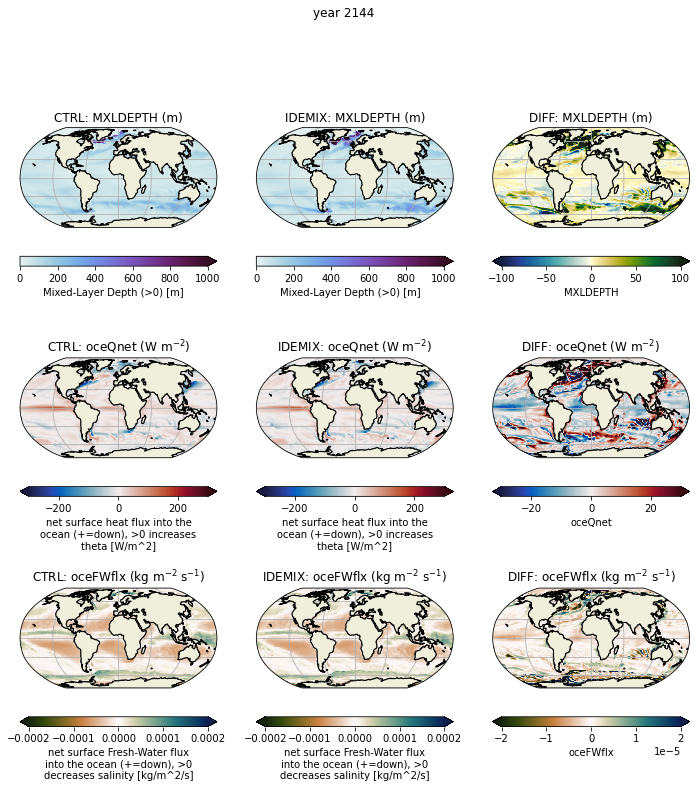

In [19]:
#plt.close('all')
#mytindex=ds1.time.shape[0]-1
mytime=ds1.time.isel(time=mytindex)

def plot2dmap(ax,fld,levs,tstr='dummy',cmap=None):
    
    ax.set_global()
    # for iface in [0,1,2,3,4,5,6,7,8,9,10,11,12]:
    # for iface in [0,1,2,3,4,5,10,11,12]:
    for iface in range(13):
        if iface==12: 
            clrbr=True
            # cbarargs={"orientation": "horizontal"}
            cbarargs={"extend": "both", "orientation": "horizontal"}
            if levs.vmin==0.: 
                cbarargs["extend"] = "max"
        else:
            clrbr=False
            cbarargs=None

        fld.isel(face=iface).plot.pcolormesh(ax=ax, transform=cart.crs.PlateCarree(), x="XC", y="YC", norm=levs,
                                             add_colorbar=clrbr, cmap=cmap, cbar_kwargs=cbarargs)
    
    ax.set_title('%s'%(tstr))
    ax.coastlines()
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines()

proj=cart.crs.Robinson()#central_longitude=180.0-19) #central_longitude=7.0)
#proj=cart.crs.PlateCarree() #central_longitude=161.)

fig, ax = plt.subplots(nrows=3,ncols=3,sharex=True,sharey=True,figsize=(12,12),subplot_kw={'projection': proj})

dd = ds1-ds0
mask2d=ds0.hFacC.isel(k=0)
#plot2dmap(ax,ds,ds0.ETAN.isel(time=mytime).where(mask2d!=0.),colors.Normalize(vmin=-4,vmax=1),tstr='run00: ETAN (m)',cmap=cmo.dense)
#plot2dmap(ax,ds,ds0.oceQnet.isel(time=mytime).where(mask2d!=0.),colors.Normalize(vmin=-200,vmax=200),tstr='run00: oceQnet (W$\,$m$^{-2}$)',cmap=cmo.balance)
plot2dmap(ax[0,0],ds0.MXLDEPTH.sel(time=mytime).where(mask2d!=0.),colors.Normalize(vmin=0,vmax=1000.),tstr=rname0+': MXLDEPTH (m)',cmap=cmo.dense)
plot2dmap(ax[0,1],ds1.MXLDEPTH.sel(time=mytime).where(mask2d!=0.),colors.Normalize(vmin=0,vmax=1000.),tstr=rname1+': MXLDEPTH (m)',cmap=cmo.dense)
plot2dmap(ax[0,2], dd.MXLDEPTH.sel(time=mytime).where(mask2d!=0.),symNorm(100.),                     tstr=   'DIFF: MXLDEPTH (m)',cmap=cmo.delta)

plot2dmap(ax[1,0],ds0.oceQnet.sel(time=mytime).where(mask2d!=0.), symNorm(300), tstr=rname0+': oceQnet (W m$^{-2}$)',cmap=cmo.balance)
plot2dmap(ax[1,1],ds1.oceQnet.sel(time=mytime).where(mask2d!=0.), symNorm(300), tstr=rname1+': oceQnet (W m$^{-2}$)',cmap=cmo.balance)
plot2dmap(ax[1,2], dd.oceQnet.sel(time=mytime).where(mask2d!=0.), symNorm(30),  tstr=   'DIFF: oceQnet (W m$^{-2}$)',cmap=cmo.balance)

plot2dmap(ax[2,0],ds0.oceFWflx.sel(time=mytime).where(mask2d!=0.),symNorm(2e-4),tstr=rname0+': oceFWflx (kg m$^{-2}$ s$^{-1}$)',cmap=cmo.tarn)
plot2dmap(ax[2,1],ds1.oceFWflx.sel(time=mytime).where(mask2d!=0.),symNorm(2e-4),tstr=rname1+': oceFWflx (kg m$^{-2}$ s$^{-1}$)',cmap=cmo.tarn)
plot2dmap(ax[2,2], dd.oceFWflx.sel(time=mytime).where(mask2d!=0.),symNorm(2e-5),tstr=   'DIFF: oceFWflx (kg m$^{-2}$ s$^{-1}$)',cmap=cmo.tarn)

fig.suptitle('year %s'%(ds0.time.sel(time=mytime).data.astype('datetime64[Y]')))
fig.savefig(os.path.join(fdir,'%s_%s'%('surface2d',yearstr)),dpi=300)

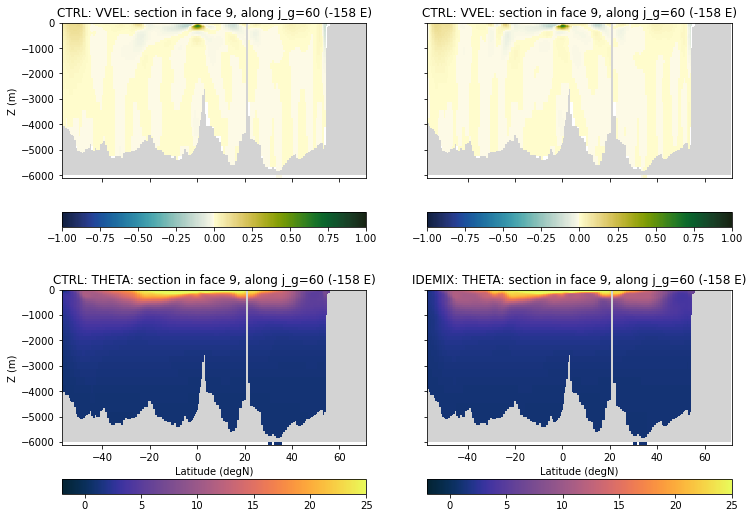

In [20]:
#plt.close("all")
#mytindex=ds1.time.shape[0]-1
#mytindex = -1
mytime=ds1.time.isel(time=mytindex)

def plotsec(ax,ds,fld,cnorm,tstr='dummy',cmap=None):
    jj=59
    iface=8
    fld0 = fld.where(fld!=0.).sel(time=mytime)
    y = np.concatenate(ds.YC[iface-1:iface+1,:,:],axis=1)[jj,:]
    d = np.concatenate(ds.Depth[iface-1:iface+1,:,:],axis=1)[jj,:]
    csf=ax.pcolormesh(y,ds.Z,np.concatenate((fld0[:,iface-1,:,:],fld0[:,iface,:,:]),axis=-1)[:,jj,:],
                      norm=cnorm,cmap=cmap)
    ax.fill_between(y,-d,-ds.Depth.max(),step='mid',facecolor='lightgrey')
    plt.colorbar(csf,ax=ax,orientation='horizontal')
    ax.set_title('%s: section in face %i, along j_g=%i (%i E)'%(tstr,iface+1,jj+1,
                                                                ds.XC.sel(face=iface,j=jj).mean()))

fig,ax=plt.subplots(2,2,figsize=(12,9),sharex=True,sharey=True);
plotsec(ax[0,0],ds0,ds0.VVEL,colors.Normalize(vmin=-1,vmax=1),rname0+': VVEL',cmap=cmo.delta)
#plotsec(ax[0,1],ds0,ds0.GGL90TKE,colors.LogNorm(vmin=1e-6,vmax=1e-2),'GGL90TKE')
plotsec(ax[1,0],ds0,ds0.THETA,colors.Normalize(vmin=-2,vmax=25),rname0+': THETA',cmap=cmo.thermal)
#plotsec(ax[1,1],ds0,ds0.GGL90Lmx.where(ds0.GGL90Lmx>1e-6),colors.LogNorm(vmin=1e-1,vmax=300),'GGL90Lmx')
plotsec(ax[0,1],ds1,ds1.VVEL,colors.Normalize(vmin=-1,vmax=1),rname0+': VVEL',cmap=cmo.delta)
plotsec(ax[1,1],ds1,ds1.THETA,colors.Normalize(vmin=-2,vmax=25),rname1+': THETA',cmap=cmo.thermal)
# plotsec(ax[0,1],ds1,(ds-ds1).VVEL,colors.Normalize(vmin=-.1,vmax=.1),rname1+': VVEL',cmap=cmo.delta)
# plotsec(ax[1,1],ds1,(ds-ds1).THETA,colors.Normalize(vmin=-.5,vmax=.5),rname1+': THETA',cmap=cmo.balance)

for b in ax[1,:]: b.set_xlabel('Latitude (degN)')
for b in ax[:,0]: b.set_ylabel('Z (m)')

compute transports

In [21]:
mocstrf0 = compute_moc(ds0.WVEL*(ds0.rA*atlantic_mask)*1e-6)
mocstrf1 = compute_moc(ds1.WVEL*(ds1.rA*atlantic_mask)*1e-6)
dp0 = calc_drake_passage_transport(ds0).values
dp1 = calc_drake_passage_transport(ds1).values

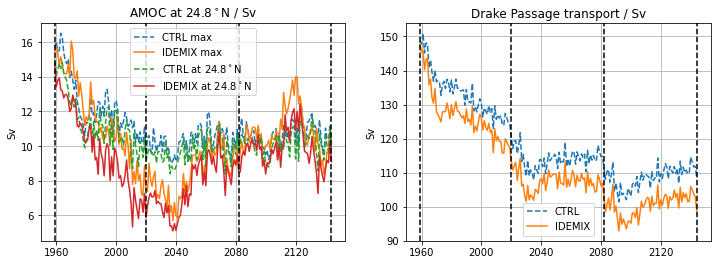

In [45]:
years0 = ds0.time.isel(time=[0::62])
fig, ax = plt.subplots(nrows=1,ncols=2,sharex=True,figsize=(12,4))
#plt.clf()
y = flat2d(grid.YC).mean(axis=-1)
iz = 22 # blow 500m
iy = 165 # northern hemisphere
ax[0].plot(ds0.time,mocstrf0[:,iz:,iy:].max(axis=1).max(axis=-1),'--',label="%s max"%(rname0))
ax[0].plot(ds1.time,mocstrf1[:,iz:,iy:].max(axis=1).max(axis=-1),'-', label="%s max"%(rname1))

for iy in [195]:
    ax[0].plot(ds0.time,mocstrf0[:,iz:,iy].max(axis=1),'--',label="%s at %4.1f$^\circ$N"%(rname0,y[iy]))
    ax[0].plot(ds1.time,mocstrf1[:,iz:,iy].max(axis=1),'-', label="%s at %4.1f$^\circ$N"%(rname1,y[iy]))

for year0 in years0:
    ax[0].axvline(x=year0.data,color='k',linestyle='--')
    
ax[0].set_ylabel('Sv')
ax[0].set_title('AMOC at %4.1f$^\circ$N / Sv'%y[iy])
ax[0].legend()
ax[0].grid()
#plt.colorbar()

ax[1].plot(ds0.time,dp0,'--',label="%s"%(rname0))
ax[1].plot(ds1.time,dp1,'-',label="%s"%(rname1))

for year0 in years0:
    ax[1].axvline(x=year0.data,color='k',linestyle='--')
    
ax[1].set_ylabel('Sv')
ax[1].set_title('Drake Passage transport / Sv')
ax[1].legend()
ax[1].grid()

fig.savefig(os.path.join(fdir,'amoc_timeseries'),dpi=300)

In [41]:
year0.data.astype('datetime64[Y]')

array('2020', dtype='datetime64[Y]')